# Scene collections - WIP

Scene collections define the scenes which are used together to calculate features, such as vitual time series or .

To create them we need the look up tables created in the previous notebook.

**TODO**: How to properly save the scene collection such that it is easy to work with them and Snakemake?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from pprint import pprint

from src import configs
prjconf = configs.ProjectConfigParser()

tilenames = prjconf.get("Params", "tiles").split(" ")
tilenames


['32UNU', '32UPU', '32UQU', '33UUP']

## Utilities



We can get all names of stored scene collections: 

In [2]:
existing_scenecoll_names = prjconf.get_scene_collection_names()
existing_scenecoll_names

['scoll01']

We can read existing scene collections and the parameters by using the name.

In [3]:
scenecoll_params_stored = prjconf.read_scene_collection_params(existing_scenecoll_names[0])
scenecoll_params_stored

{'product': ['L30'],
 'start_date': '2018-01-01',
 'end_date': '2018-12-31',
 'max_cloud_cover': 75,
 'min_spatial_coverage': 0}

In [4]:
if len(existing_scenecoll_names) > 0:
    pprint(prjconf.read_scene_collection_params(existing_scenecoll_names[0]))
    display(prjconf.read_scene_collection(existing_scenecoll_names[0], tile="32UNU").head(3))
           

{'end_date': '2018-12-31',
 'max_cloud_cover': 75,
 'min_spatial_coverage': 0,
 'product': ['L30'],
 'start_date': '2018-01-01'}


,sceneid,product,tile,date_Yj,date,cloud_cover,spatial_coverage
0,HLS.L30.T32UNU.2018010.v1.4,L30,32UNU,2018010,2018-01-10,63.0,37.0
1,HLS.L30.T32UNU.2018019.v1.4,L30,32UNU,2018019,2018-01-19,67.0,100.0
2,HLS.L30.T32UNU.2018044.v1.4,L30,32UNU,2018044,2018-02-13,35.0,28.0


## Scene collection parameter

In [5]:
scenecoll_params_all = {
    "scoll01":
    {
        "product": ["L30"],
        "start_date": "2018-01-01",
        "end_date": "2018-12-31",
        "max_cloud_cover": 75,
        "min_spatial_coverage": 0
    }
}

## Create scene collections

********************************************************************************
32UNU
Scene collection parameter:
{'end_date': '2018-12-31',
 'max_cloud_cover': 75,
 'min_spatial_coverage': 0,
 'product': ['L30'],
 'start_date': '2018-01-01'}
Number of scenes in the scene collection: 24
/home/ben/Devel/Projects/classify-hls/data/raw/scene_collections/32UNU/df_scoll01.csv exists. It is NOT overwritten! Delete it first if you are sure to write it.
********************************************************************************
32UPU
Scene collection parameter:
{'end_date': '2018-12-31',
 'max_cloud_cover': 75,
 'min_spatial_coverage': 0,
 'product': ['L30'],
 'start_date': '2018-01-01'}
Number of scenes in the scene collection: 29
/home/ben/Devel/Projects/classify-hls/data/raw/scene_collections/32UPU/df_scoll01.csv exists. It is NOT overwritten! Delete it first if you are sure to write it.
********************************************************************************
32UQU
Scene colle

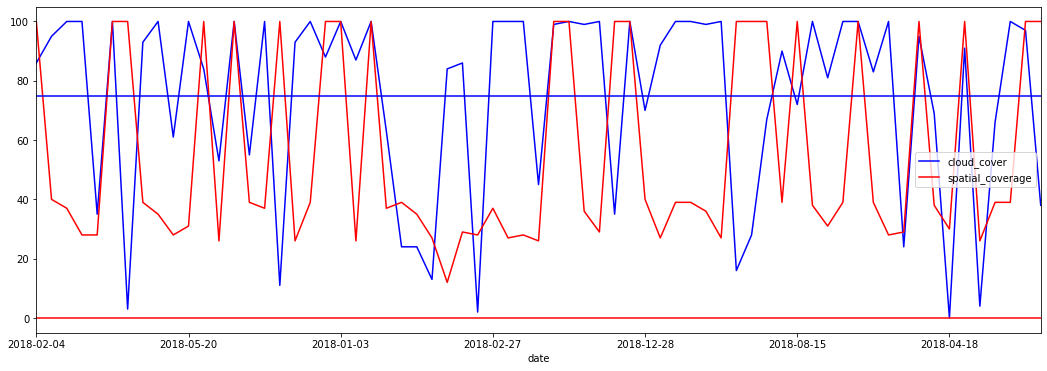

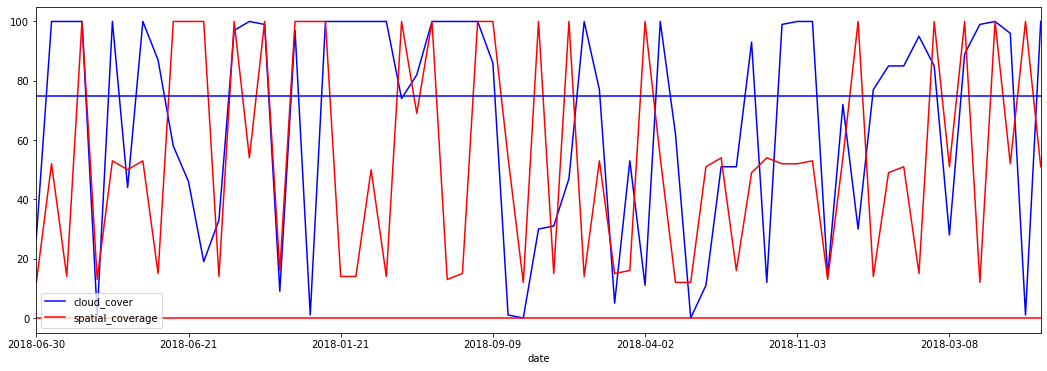

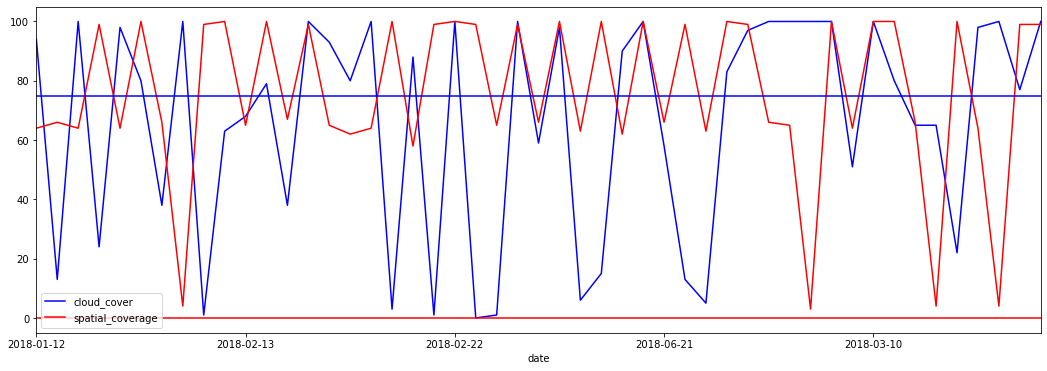

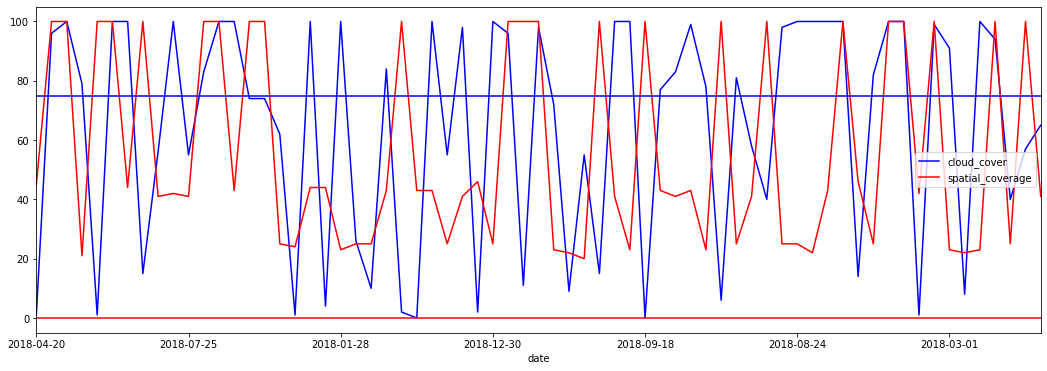

In [7]:
scenecoll_name = "scoll01"

for tile in tilenames:
    scenecoll_params = scenecoll_params_all[scenecoll_name]
    exist_ok=True


    print("*"  * 80)
    print(tile)
    print("Scene collection parameter:")
    pprint(scenecoll_params)

    path__hls_tile_lut = prjconf.get_path("Raw", "hls_tile_lut", tile=tile)
    df_scenes = pd.read_csv(path__hls_tile_lut)

    # plot teh selection criteria
    ax = df_scenes.plot(x="date", y="cloud_cover", color='b', figsize=(18, 6))
    ax = df_scenes.plot(x="date", y="spatial_coverage", color='r', ax=ax)
    ax.axhline(y=scenecoll_params["min_spatial_coverage"], color='r')
    ax.axhline(y=scenecoll_params["max_cloud_cover"], color='b')

    idx = (df_scenes["date"] >= scenecoll_params["start_date"]) & \
          (df_scenes["date"] <= scenecoll_params["end_date"]) & \
          (df_scenes["product"].isin(scenecoll_params["product"])) & \
          (df_scenes["cloud_cover"] <= scenecoll_params["max_cloud_cover"]) & \
          (df_scenes["spatial_coverage"] >= scenecoll_params["min_spatial_coverage"])
    df_scenecoll = df_scenes[idx] \
        .reset_index(drop=True) \
        .drop("path", axis=1) \
        .sort_values(["product", "date", "cloud_cover"])

    #display(df_scenecoll.head())

    print(f"Number of scenes in the scene collection: {len(df_scenecoll)}")

    # Write a scene collection.
    # Note (!!!) that for your own safety this throws an error if it exists.
    # scenecoll_name = f"scenecoll01__tile_{tile}"
    # scenecoll_name += f"__date_{scenecoll_params['start_date']}T{scenecoll_params['end_date']}"
    # scenecoll_name += f"__product_{'-'.join(scenecoll_params['product'])}"
    # scenecoll_name += f"__maxcc_{scenecoll_params['max_cloud_cover']}"
    # scenecoll_name += f"__minsc_{scenecoll_params['min_spatial_coverage']}"

    prjconf.write_scene_collection(df_scenecoll, scenecoll_name, scenecoll_params, tile=tile, exist_ok=exist_ok)